In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
from scipy.io import wavfile
import tensorflow as tf
import utilities as util
import matplotlib.pylab as plt 


In [2]:
%%time
nps_uniq, dfreqs, notes = util.precompute_spect()
smallest_nps = 44100/24 * 4/3 
smallest_nps = 2**int(np.log2(smallest_nps))
note_freq = util.frequencies('A0', 'D8')
sample_files, target_vals = util.gather_samples() # Guitar, Trombone, Piano

CPU times: user 1.22 ms, sys: 206 µs, total: 1.43 ms
Wall time: 1.17 ms


In [ ]:
v = util.preprocess('../samples/Other/Guitar.wav', nps_uniq, dfreqs, notes, smallest_nps, note_freq)

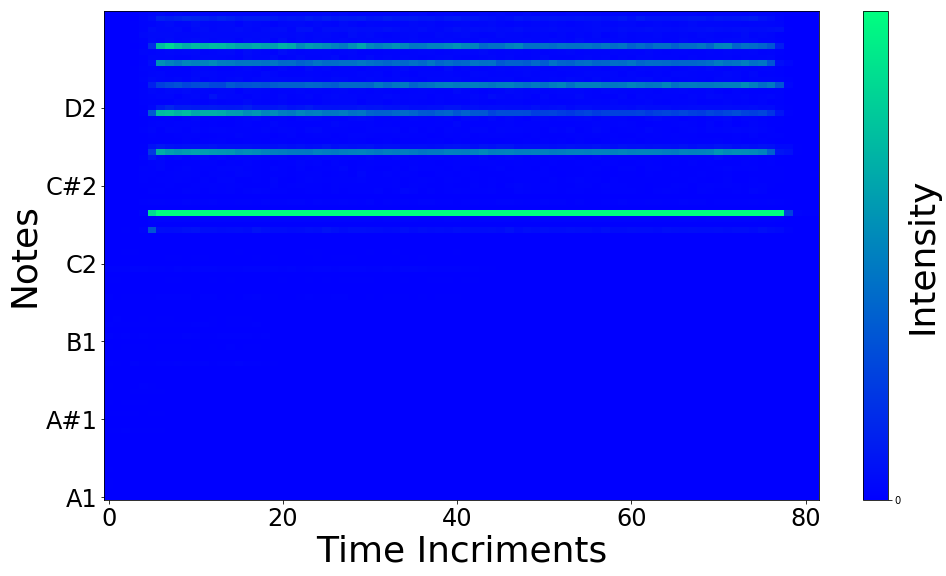

In [4]:
import numpy as np
from scipy.io import wavfile
import tensorflow as tf
import utilities as util
import matplotlib.pylab as plt 

nps_uniq, dfreqs, notes = util.precompute_spect()
smallest_nps = 44100/24 * 4/3 
smallest_nps = 2**int(np.log2(smallest_nps))
note_freq = util.frequencies('A0', 'D8')


v = util.preprocess('../samples/Other/Guitar.wav', nps_uniq, dfreqs, notes, smallest_nps, note_freq)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(v)
    
plt.figure(figsize=(16,9))

cmap = plt.get_cmap('winter')
cmap.set_under(color='k', alpha=None)

plt.imshow(x[:,3:85],cmap=cmap, vmax=50000000)

# plt.colorbar()


plt.colorbar(ticks=[0]).set_label('Intensity',fontsize=36)

plt.gca().set_aspect('auto')
# plt.title('Spectrogram',fontsize=48)
plt.xlabel('Time Incriments',fontsize=36)
plt.ylabel('Notes',fontsize=36)
plt.yticks(ticks=list(range(0, 83)),labels=util.note_names('A1','A8'))
plt.gca().tick_params(labelsize=24)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)
plt.gca().invert_yaxis()
plt.savefig('New_Spectrogram.png')

In [ ]:
x.shape

In [ ]:
import matplotlib.pylab as plt 

In [ ]:
notes=util.note_names('A1','A8')

In [ ]:
len(notes)

In [ ]:
plt.figure(figsize=(16,9))

cmap = plt.get_cmap('winter')
cmap.set_under(color='k', alpha=None)

plt.imshow(x[:,3:85],cmap=cmap, vmax=50000000)

# plt.colorbar()

plt.colorbar(ticks=[0]).set_label('Intensity',fontsize=36)

plt.gca().set_aspect('auto')
# plt.title('Spectrogram',fontsize=48)
plt.xlabel('Time Incriments',fontsize=36)
plt.ylabel('Notes',fontsize=36)
plt.yticks(ticks=list(range(0, 83)),labels=notes)
plt.gca().tick_params(labelsize=24)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)
plt.gca().invert_yaxis()


In [ ]:
np.where(x.sum(0)==0)

In [ ]:
95/172, 4.5/8

In [ ]:
x.shape

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=wavfile.WavFileWarning)

In [ ]:
%%time
# Preprocess all of the sample files
# Create lists of all of the frequencies, times and spectrograms
all_freqs = note_freq[:-1]
all_specs = []
all_names = []
for sf in sample_files:
    # TODO: TF_SPEC needs all of these constants. Is there a way that we can reduce the parameters?
    s = util.preprocess(sf, nps_uniq, dfreqs, notes, smallest_nps, note_freq)
    all_specs.append(s)

In [ ]:
s.shape

In [ ]:
n_inputs=95*88

In [ ]:
X = tf.placeholder(tf.float16, shape=(None,n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [ ]:
%%time
# X = tf.stack(all_specs)
# nn = tf.layers.dense(x, 100)  # 12 notes, 8 octaves, >= 96 starting nodes
# nn = tf.layers.dense(nn, 150) # Expansion by 1.5x for variations, and more precise calculations
# encoded = tf.layers.dense(nn, 3) # Currently 3 for trombone, guitar, piano
# ret = tf.layers.flatten(encoded)
n_hidden1 = n_inputs
n_hidden2 = int(n_inputs*1.5)
n_outputs = 3

with tf.name_scope("network"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu) # Play with activations
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu) # Play with activations
    net_results = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [ ]:
%%time

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=net_results)
    loss = tf.reduce_mean(xentropy, name="loss")

In [ ]:
%%time
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [ ]:
%%time
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(tf.cast(net_results, tf.float32), y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
spectrograms = []
with tf.Session() as sess:
    init.run()
    spectrograms = sess.run(all_specs)

In [ ]:
%%time
new_specs22 = []
for i in range(len(all_specs)):
    new_spectrograms = []
    new_spectrograms = np.concatenate(spectrograms[i][:,:95]).ravel()
    new_specs22.append(new_spectrograms)

In [ ]:
new_specs22

In [ ]:
%%time

n_epochs = 10
batch_size = 3
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
#         for iteration in range(len(new_specs22) // batch_size):
        X_batch = new_specs22
        Y_batch = [0,1,2]#target_vals
        sess.run(training_op, feed_dict={X: np.stack(X_batch),
                                         y: np.array(Y_batch)})
#         acc_train = accuracy.eval(feed_dict={X: X_batch, y: [0,1,2]})
        acc_val = accuracy.eval(feed_dict={X: X_batch, y: Y_batch})
        print(epoch, "Train accuracy:", 0, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./FirstNetwork.ckpt")

In [ ]:
np.stack(X_batch).shape

In [ ]:
[x.shape for x in spectrograms]

In [ ]:
new_sample_files = []
new_target_vals = []
new_location = '../samples/'
new_instruments = ['Trombone', 'Guitar', 'Piano']
for i, new_name in enumerate(new_instruments):
    for new_note in (util.note_names('C1', 'C#1')):
        for j in range(2, 3):
            new_file_name = new_location + new_name+"/"+new_name +"_"+new_note[:-1]+"("+str(j)+").wav"
            new_sample_files.append(new_file_name)
            new_target_vals.append(i)

In [ ]:
%%time
# Preprocess all of the sample files
# Create lists of all of the frequencies, times and spectrograms
new_all_freqs = note_freq[:-1]
new_all_specs = []
new_all_names = []
for sf in new_sample_files:
    # TODO: TF_SPEC needs all of these constants. Is there a way that we can reduce the parameters?
    new_s = util.preprocess(sf, nps_uniq, dfreqs, notes, smallest_nps, note_freq)
    new_all_specs.append(s)

In [ ]:
with tf.Session() as sess:
    init.run()
    spectrograms2 = sess.run(new_all_specs)

In [ ]:
%%time
new_specs33 = []
for i in range(len(new_all_specs)):
    new_spectrograms2 = []
    new_spectrograms2 = np.concatenate(spectrograms2[i][:,:95]).ravel()
    new_specs33.append(new_spectrograms2)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./FirstNetwork.ckpt")
    X_new_scaled = new_specs33
    Z = net_results.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

In [ ]:
y_pred

In [ ]:
%%time

guitar_samples = ['../samples/Guitar/Guitar_C(1).wav', '../samples/Guitar/Guitar_C#(1).wav', 
                  '../samples/Guitar/Guitar_D(1).wav', '../samples/Guitar/Guitar_D#(1).wav', 
                  '../samples/Guitar/Guitar_E(1).wav',  '../samples/Guitar/Guitar_F(1).wav', 
                  '../samples/Guitar/Guitar_F#(1).wav', '../samples/Guitar/Guitar_G(1).wav', 
                  '../samples/Guitar/Guitar_G#(1).wav', '../samples/Guitar/Guitar_A(1).wav', 
                  '../samples/Guitar/Guitar_A#(1).wav', '../samples/Guitar/Guitar_B(1).wav']

guitar_specs = []
for gs in guitar_samples:
    g_s = util.preprocess(gs, nps_uniq, dfreqs, notes, smallest_nps, note_freq)
    guitar_specs.append(g_s)

In [ ]:
v = util.preprocess('../samples/Guitar/Guitar_C#(1).wav', nps_uniq, dfreqs, notes, smallest_nps, note_freq)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(v)